In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
path='/content/drive/My Drive/dl/faces94/'

In [0]:
import numpy as np
import pandas as pd
import tensorflow.keras as keras
from keras.layers import Input, Dense
from keras.models import Model
import glob as glob
from skimage.transform import resize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [0]:
%matplotlib inline

In [0]:
image_paths = glob.glob(path+'/*/*/*.jp*g')

In [0]:
# image_dim=(200, 180, 3)

In [0]:
transformed_shape = (128, 128, 3)

In [0]:
vector_size=np.prod(transformed_shape)

In [0]:
image_vectors = np.empty((len(image_paths), vector_size))
images = np.empty((len(image_paths), *transformed_shape))

In [0]:
labels=[]
for i in range(len(image_paths)):
  image=plt.imread(image_paths[i])
  image=resize(image, output_shape=transformed_shape)
  labels.append(image_paths[i].split('/')[6])
  image_vectors[i]=image.reshape((vector_size))

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [0]:
image_vectors[0]

array([0.45684168, 0.68037109, 0.27644953, ..., 0.13882889, 0.16094899,
       0.03797105])

In [0]:
image_vectors.shape

(3079, 49152)

In [0]:
len(labels)

3079

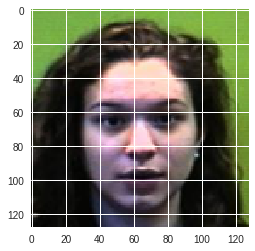

In [0]:
plt.imshow(image_vectors[0].reshape(transformed_shape))

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(image_vectors, labels, test_size=0, random_state=42)

In [0]:
input_image=Input((vector_size, ))

In [0]:
encoding_dim=100

In [0]:
encoded=Dense(encoding_dim*8, activation='relu')(input_image)
encoded=Dense(encoding_dim*4, activation='relu')(encoded)
encoded=Dense(encoding_dim*2, activation='relu')(encoded)
encoded=Dense(encoding_dim, activation='relu')(encoded)
decoded=Dense(encoding_dim*2, activation='relu')(encoded)
decoded=Dense(encoding_dim*4, activation='relu')(encoded)
decoded=Dense(encoding_dim*8, activation='relu')(decoded)
decoded=Dense(vector_size, activation='sigmoid')(decoded)


In [0]:
autoencoder=Model(input_image, decoded)

In [0]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 49152)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 800)               39322400  
_________________________________________________________________
dense_10 (Dense)             (None, 400)               320400    
_________________________________________________________________
dense_11 (Dense)             (None, 200)               80200     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_14 (Dense)             (None, 400)               40400     
_________________________________________________________________
dense_15 (Dense)             (None, 800)               320800    
__________

In [0]:
encoder=Model(input_image, encoded)

In [0]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 49152)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 800)               39322400  
_________________________________________________________________
dense_10 (Dense)             (None, 400)               320400    
_________________________________________________________________
dense_11 (Dense)             (None, 200)               80200     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               20100     
Total params: 39,743,100
Trainable params: 39,743,100
Non-trainable params: 0
_________________________________________________________________


In [0]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [0]:
autoencoder.fit(X_train, X_train, batch_size=128, epochs=100, validation_data=[X_train, X_train], shuffle=True)

Train on 3079 samples, validate on 3079 samples
Epoch 1/100
3079/3079 [==============================] - 9s 3ms/step - loss: 0.6291 - val_loss: 0.6078
Epoch 2/100
3079/3079 [==============================] - 7s 2ms/step - loss: 0.6012 - val_loss: 0.5953
Epoch 3/100
3079/3079 [==============================] - 7s 2ms/step - loss: 0.5861 - val_loss: 0.5843
Epoch 4/100
3079/3079 [==============================] - 7s 2ms/step - loss: 0.5781 - val_loss: 0.5725
Epoch 5/100
3079/3079 [==============================] - 7s 2ms/step - loss: 0.5717 - val_loss: 0.5678
Epoch 6/100
3079/3079 [==============================] - 7s 2ms/step - loss: 0.5655 - val_loss: 0.5617
Epoch 7/100
3079/3079 [==============================] - 7s 2ms/step - loss: 0.5610 - val_loss: 0.5596
Epoch 8/100
3079/3079 [==============================] - 7s 2ms/step - loss: 0.5567 - val_loss: 0.5539
Epoch 9/100
3079/3079 [==============================] - 7s 2ms/step - loss: 0.5522 - val_loss: 0.5496
Epoch 10/100
3079/3079 [=

In [0]:
decoded_imgs = autoencoder.predict(X_train)

In [0]:
encoded_imgs=encoder.predict(X_train)

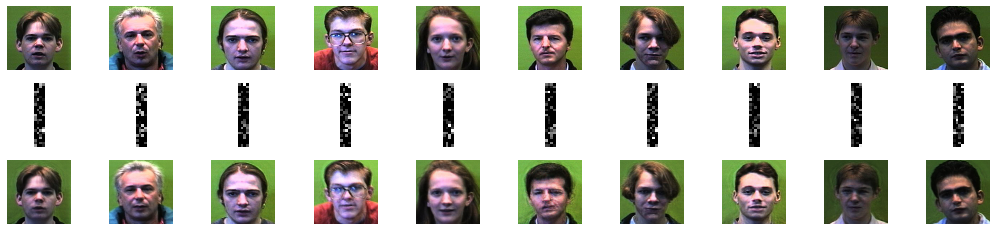

In [0]:
num_images = 10
np.random.seed(42)

rand_idx = np.random.randint(X_train.shape[0], size=num_images)
encoded_imgs = encoder.predict(X_train)
decoded_imgs = autoencoder.predict(X_train)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(rand_idx):
    # plot original image
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(X_train[image_idx].reshape(128, 128, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images + i + 1)
    plt.imshow(encoded_imgs[image_idx].reshape(25, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # plot reconstructed image
    ax = plt.subplot(3, num_images, 2*num_images + i + 1)
    plt.imshow(decoded_imgs[image_idx].reshape(128, 128, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [0]:
filename = "latent_space.csv" 

In [0]:
data_frame=pd.DataFrame(data=encoded_imgs)

In [0]:
data_frame['Labels']=labels

In [0]:
data_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Labels
0,0.000000,0.0,11.185415,28.254009,12.860683,0.0,9.479907,6.753431,8.111674,13.151500,...,0.0,0.000000,9.916380,0.0,0.000000,9.888819,0.002459,0.0,6.497449,female
1,7.771168,0.0,10.362153,16.342730,5.102306,0.0,0.000000,19.084284,7.202781,12.137473,...,0.0,0.000000,0.000000,0.0,4.212551,0.000000,1.465007,0.0,4.255036,female
2,0.000000,0.0,34.591503,25.539577,8.687786,0.0,0.000000,15.090862,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,3.059576,9.045457,0.0,6.147257,female
3,0.000000,0.0,3.075369,5.501989,0.000000,0.0,0.000000,8.021910,0.000000,13.517614,...,0.0,0.000000,15.803641,0.0,0.000000,5.976622,9.154837,0.0,22.860945,female
4,0.000000,0.0,0.650101,18.929258,0.000000,0.0,12.924743,0.000000,0.000000,17.787205,...,0.0,2.490288,1.641360,0.0,5.363613,7.288731,0.000000,0.0,0.448564,female


In [0]:
#Saving image
data_frame.to_csv('/content/drive/My Drive/encoded_images.csv', sep='\t', encoding='utf-8')